In [5]:
from IPython.display import HTML
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

# Foundations of Data Mining: Assignment 1

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [6]:
# Please fill in your names here
NAME_STUDENT_1 = "A. Siganos"
NAME_STUDENT_2 = "J. Gómez Robles"

In [7]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "all"

# Increase the number of columns to be shown by pandas
pd.set_option('display.width', 800)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 400)


### Imports (Run it always!)

In [164]:
################################################################################
####################### Imports needed for this question #######################
################################################################################

# For plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

# To split data into test-train sets
from sklearn.model_selection import train_test_split, ShuffleSplit

# Linear regression algorithms
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Linear classifier
from sklearn.neighbors import KNeighborsClassifier

# For the Scaler requested
from sklearn.preprocessing import StandardScaler

# For cross-validation
from sklearn.model_selection import cross_val_score

# For pipelines
from sklearn.pipeline import make_pipeline

# For Grid Search (best parameters selection)
from sklearn.model_selection import GridSearchCV 

# For Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# For Gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

# For logging
import time

# For last question
from sklearn.metrics import roc_auc_score

## MoneyBall (5 points, 1+2+1+1)
In the early 2000s, 2 baseball scouts completely changed the game of baseball by analysing the available data about baseball players and hiring the best ones.
The [MoneyBall dataset](https://www.openml.org/d/41021) contains this data (click the link for more details). The goal is to accurately predict the number of 'runs' each player can score. 

### Global variables (Run it before going to solutions!)

In [363]:
################################################################################
############################### Global variables ###############################
################################################################################

# Categorical features in the dataset (from OpenML description)
categoricalFeatures = ["Year", "Team", "League", "Playoffs", "RankSeason", "RankPlayoffs", "G"]

# Set of all algorithms we are using in this question
algorithms = { "linear": LinearRegression(), "ridge": Ridge(), 
               "lasso": Lasso(), "elasticnet": ElasticNet(),
               "knn": KNeighborsClassifier() }


### Methods (Run it before going to solutions!)

In [364]:
# Fix the MoneyBall dataset to mark nominal features (columns)
# as categorical (category) or strings (str).
#
# Returns a copy of the dataset (source) to avoid variable reference problems
def fixCategorical(source, categoriesAsString = False, makeCopy = True):
    """This method fix the MoneyBall nominal features"""

    # If makeCopy is true, we create a new object based on the parameter
    if makeCopy:
        dataset = source.copy()
    # otherwise, we alter the reference in the parameter
    else:
        dataset = source

    # Change the type to 'category' or to 'str'
    for col in dataset.columns:
        if col in categoricalFeatures: 
            if categoriesAsString:
                dataset[col] = dataset[col].astype(str)
            else:
                dataset[col] = dataset[col].astype('category')

    return dataset
# END OF fixCategorical

In [365]:
moneyball = oml.datasets.get_dataset(41021) # Download MoneyBall data
# Get the predictors X and the target y
X, y, attribute_names = moneyball.get_data(target = moneyball.default_target_attribute, 
                                           return_attribute_names = True)
# Describe the data with pandas, just to get an overview
ballframe = pd.DataFrame(X, columns = attribute_names)

# Added by team (have this variable also available as dataframe, to ease exploration)
targetframe = pd.DataFrame(y, columns = ["RS"])

ballframe.describe()

Team  League     Year       RA        W      OBP      SLG       BA  Playoffs  RankSeason  RankPlayoffs        G    OOBP    OSLG
count  1232.00  1232.0  1232.00  1232.00  1232.00  1232.00  1232.00  1232.00    1232.0      244.00        244.00  1232.00  420.00  420.00
mean     15.67     0.5  1988.96   715.08    80.90     0.33     0.40     0.26       0.2        2.12          1.72     3.92    0.33    0.42
std       9.72     0.5    14.82    93.08    11.46     0.02     0.03     0.01       0.4        1.74          1.10     0.62    0.02    0.03
min       0.00     0.0  1962.00   472.00    40.00     0.28     0.30     0.21       0.0        0.00          0.00     0.00    0.29    0.35
25%       7.00     0.0  1976.75   649.75    73.00     0.32     0.38     0.25       0.0        1.00          1.00     4.00    0.32    0.40
50%      16.00     0.5  1989.00   709.00    81.00     0.33     0.40     0.26       0.0        2.00          2.00     4.00    0.33    0.42
75%      23.00     1.0  2002.00   774.25    89.00     0.34     0.42     0.27       0.0        3.00          3.00     4.00    0.34    0.44
max      38.00     1.0  2012.00  1103.00   116.00     0.37     0.49     0.29       1.0        7.00          4.00     7.00    0.38    0.50

### Understanding features

In [366]:
# OBSERVING SOME VALUES IN THE DATASET

# See types (the usage of DF is only for visual aspects)
pd.DataFrame(ballframe.dtypes, columns = ["Types"])

# See how the information looks like
ballframe.head()


Types
Team          float32
League        float32
Year          float32
RA            float32
W             float32
OBP           float32
SLG           float32
BA            float32
Playoffs      float32
RankSeason    float32
RankPlayoffs  float32
G             float32
OOBP          float32
OSLG          float32

Team  League    Year     RA     W   OBP   SLG    BA  Playoffs  RankSeason  RankPlayoffs    G  OOBP  OSLG
0   0.0     1.0  2012.0  688.0  81.0  0.33  0.42  0.26       0.0         NaN           NaN  4.0  0.32  0.41
1   1.0     1.0  2012.0  600.0  94.0  0.32  0.39  0.25       1.0         3.0           4.0  4.0  0.31  0.38
2   2.0     0.0  2012.0  705.0  93.0  0.31  0.42  0.25       1.0         4.0           3.0  4.0  0.31  0.40
3   3.0     0.0  2012.0  806.0  69.0  0.31  0.41  0.26       0.0         NaN           NaN  4.0  0.33  0.43
4   4.0     1.0  2012.0  759.0  61.0  0.30  0.38  0.24       0.0         NaN           NaN  4.0  0.34  0.42

In [367]:
# UNDERSTANDING THE CATEGORICAL FEATURES

# Create dataset with categorical features type fixed
ballframeCategorical = fixCategorical(ballframe)

myOutput = []

# Print the categories of each nominal feature
for feature in ballframeCategorical.dtypes.index:
    if feature in categoricalFeatures:
        # Print the unique values (categories) 
        categories = np.sort( ballframeCategorical[feature].unique() )
        myOutput.append((feature, len(categories), categories))

myOutput = pd.DataFrame(myOutput, columns = ["Feature", "Number of categories", "Categories"])
myOutput

Feature  Number of categories                                                                                                                                                                                                                                                                                                                                                                                Categories
0          Team                    39                                                                                                                                                          [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0]
1        League                     2                                                                                                                                                                                                                                                                                                                                                                                [0.0, 1.0]
2          Year                    47  [1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0]
3      Playoffs                     2                                                                                                                                                                                                                                                                                                                                                                                [0.0, 1.0]
4    RankSeason                     9                                                                                                                                                                                                                                                                                                                                             [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]
5  RankPlayoffs                     6                                                                                                                                                                                                                                                                                                                                                            [0.0, 1.0, 2.0, 3.0, 4.0, nan]
6             G                     8                                                                                                                                                                                                                                                                                                                                                  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

In [368]:
# TAKE A LOOK AT THE TARGET VALUE FIRST, SO WE CAN GET AN IDEA OF WHAT ARE WE PREDICTING

# Print type (float as expected because of regression)
pd.DataFrame(targetframe.dtypes, columns = ["Type"])

# Get descriptive statistics
targetframe.describe()

Type
RS  float64

RS
count  1232.00
mean    715.08
std      91.53
min     463.00
25%     652.00
50%     711.00
75%     775.00
max    1009.00

### Visualization (Exploratory analysis)

1 . Visually explore the data. Plot the distribution of each feature (e.g. histograms), as well as the target. Visualize the dependency of the target on each feature (use a 2d scatter plot). Is there anything that stands out? Is there something that you think might require special treatment?
- Feel free to create additional plots that help you understand the data
- Only visualize the data, you don't need to change it (yet)

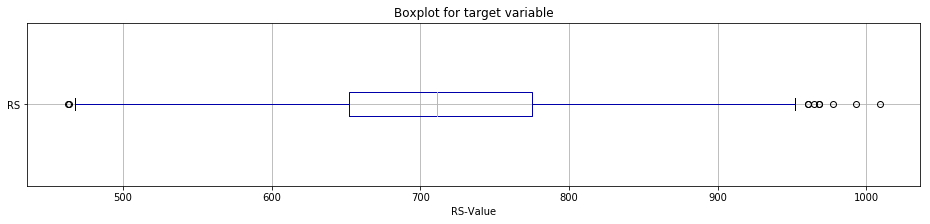

In [369]:
# EXPLORING TARGET 

# Figsize in inches, vert controls orientation
fig, axis = plt.subplots()
pltl = axis.set_title("Boxplot for target variable")
plax = axis.set_xlabel("RS-Value")
fig.set_size_inches(16, 3)
targetBP = targetframe.boxplot(ax = axis, vert = False)

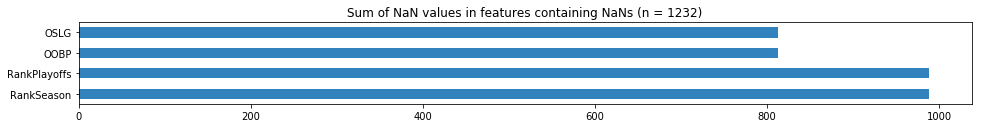

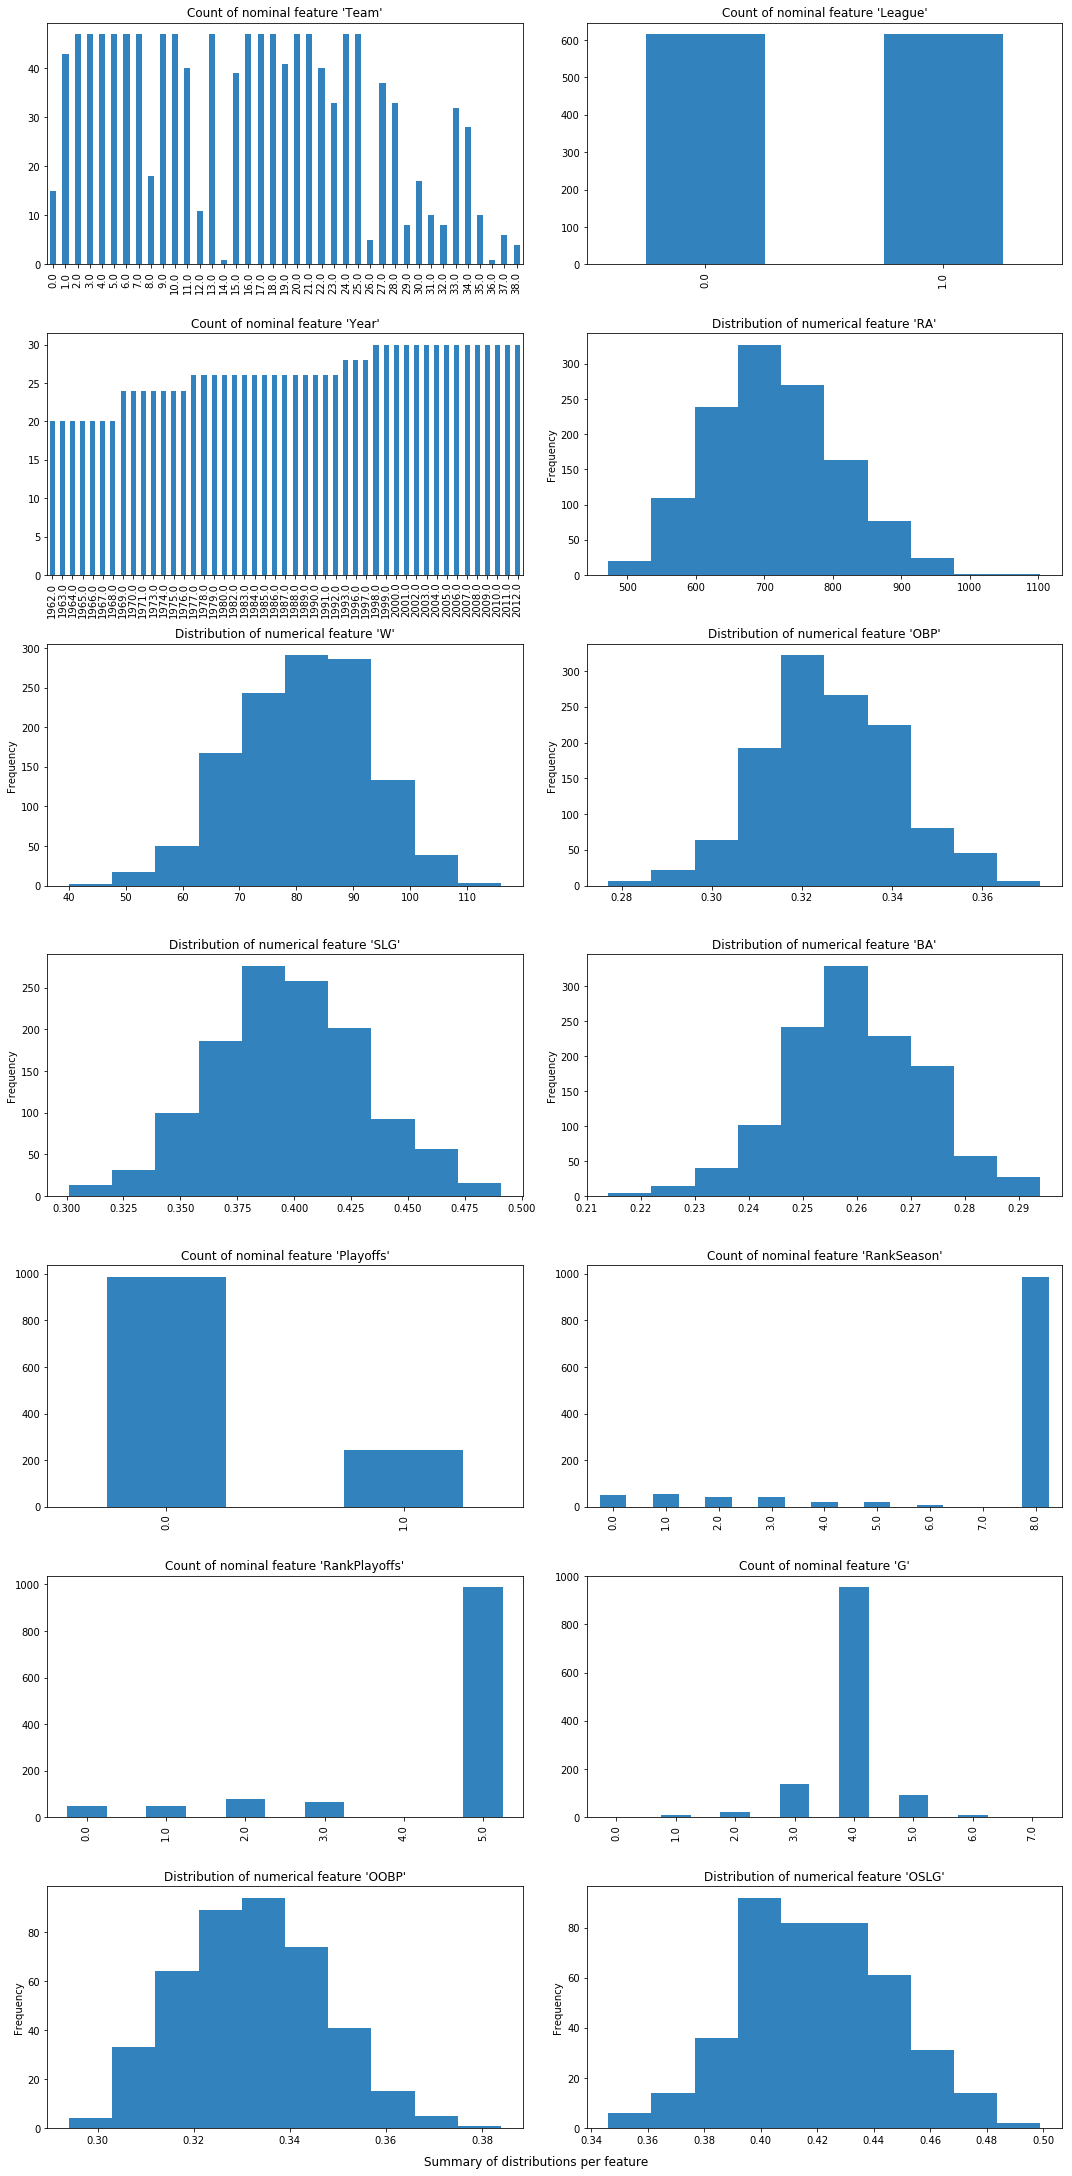

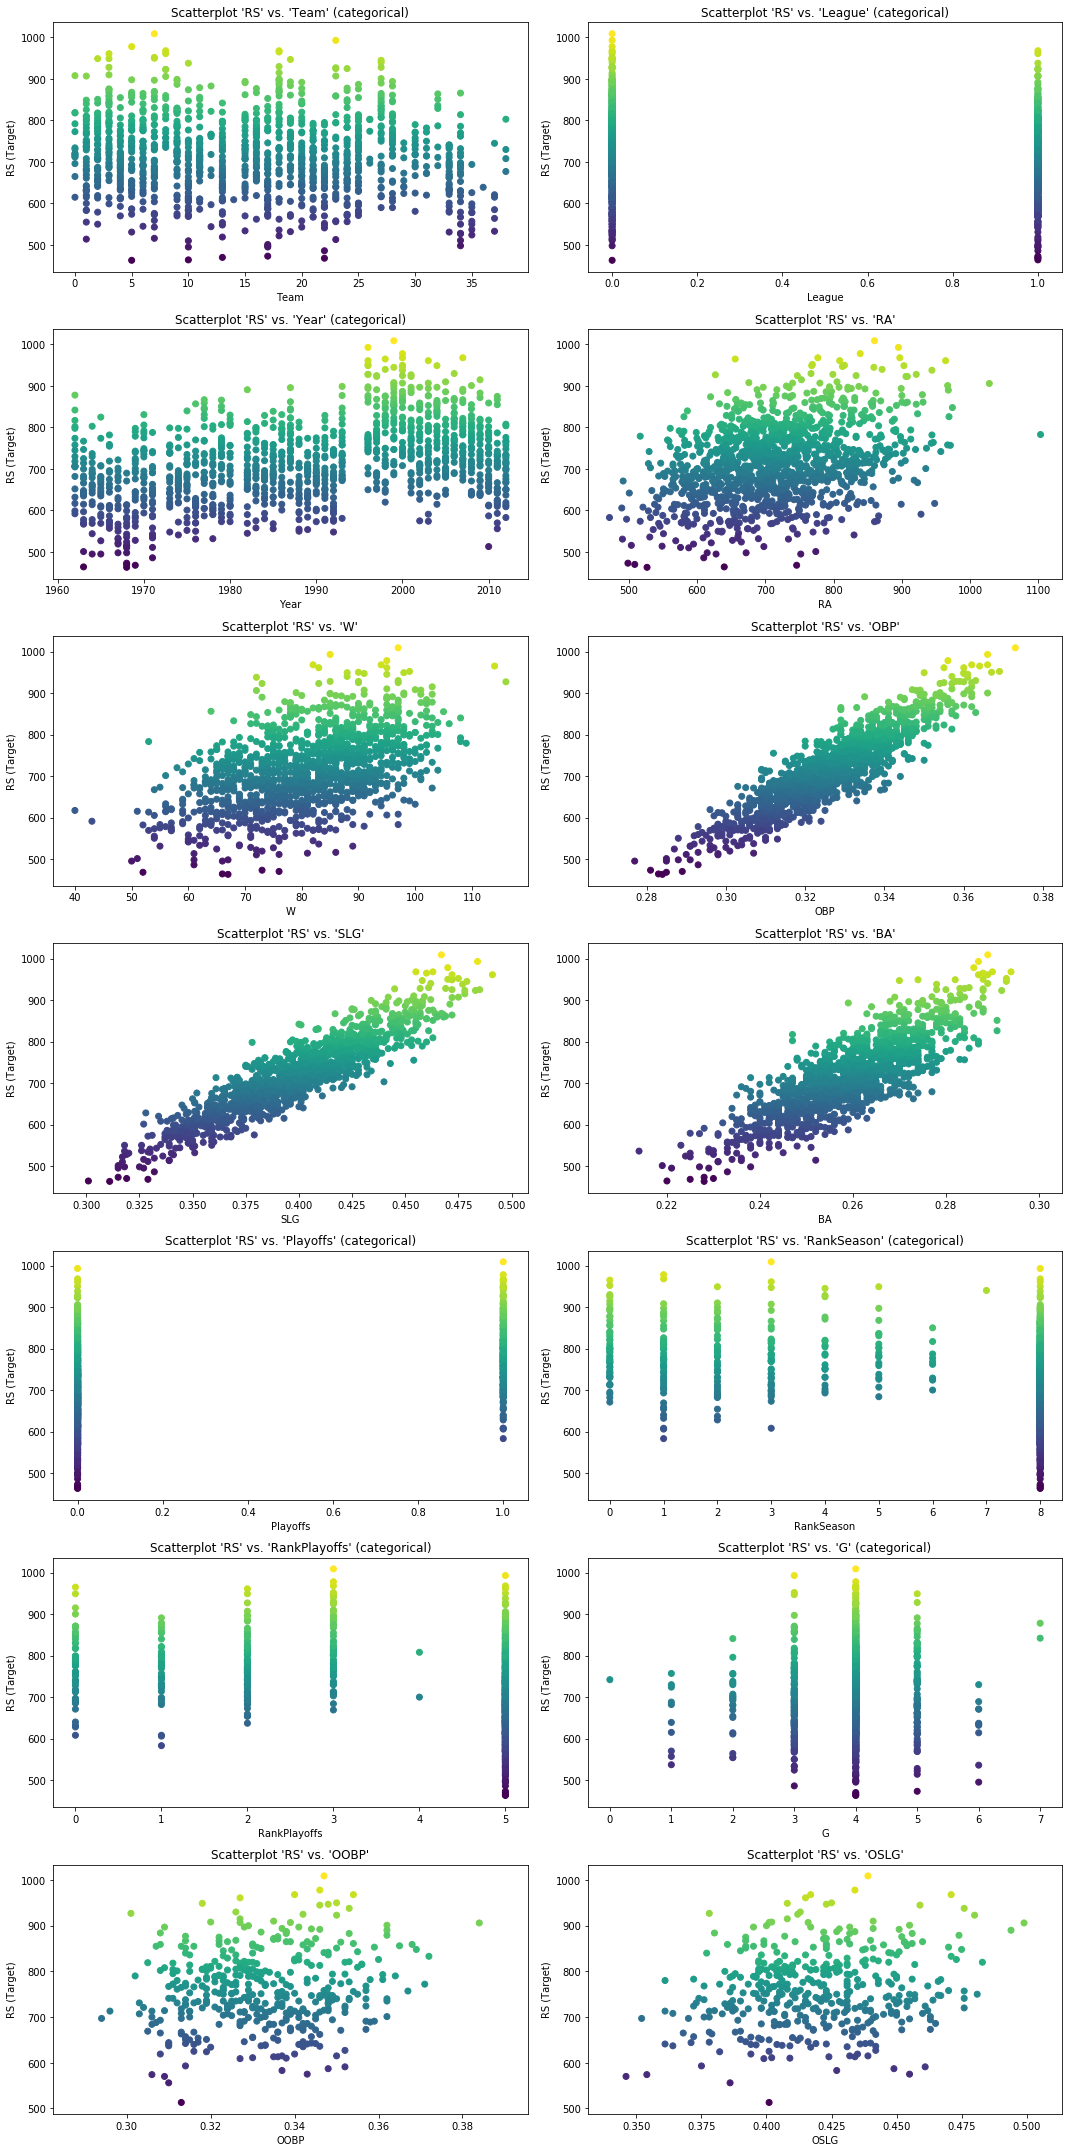

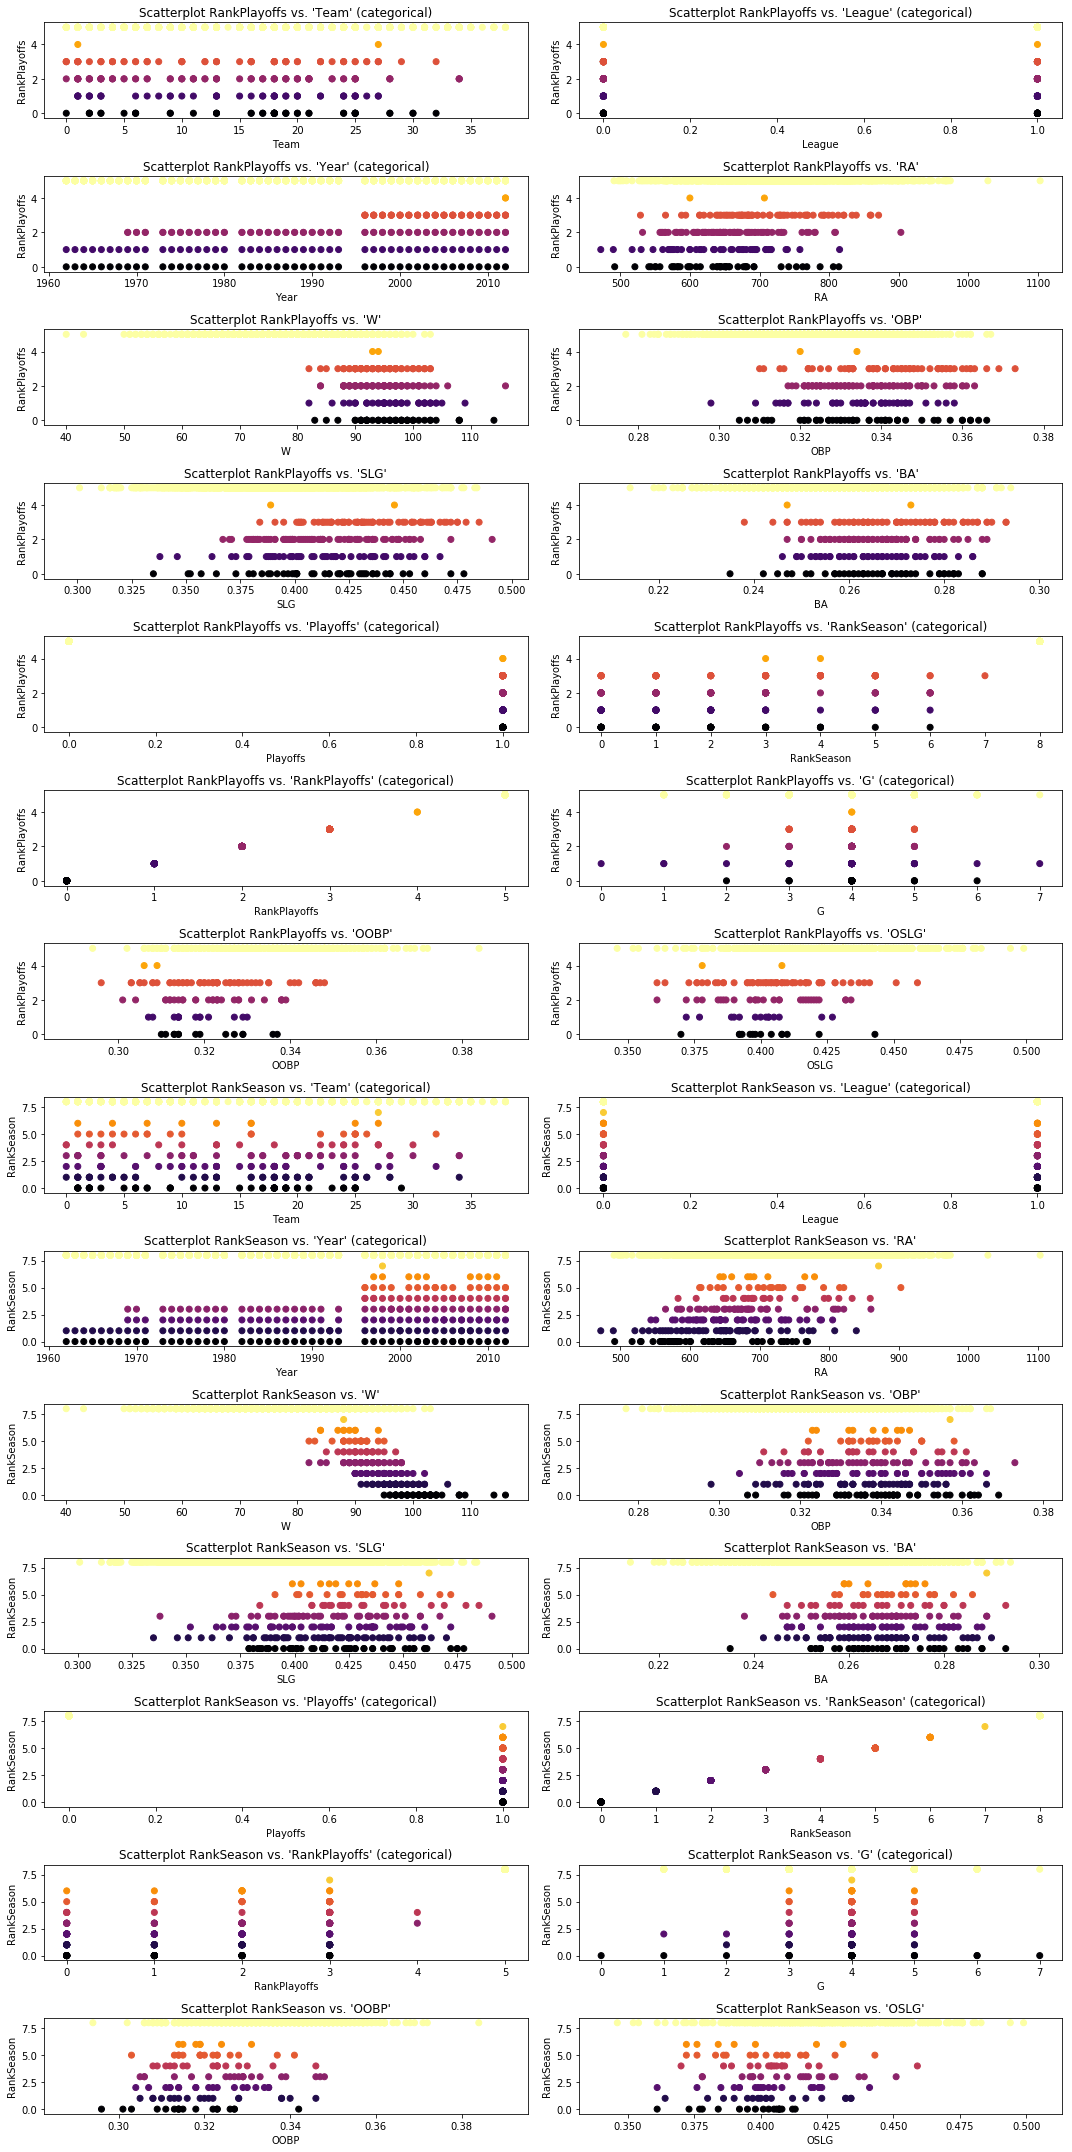

In [370]:
# To ease the graphical representation, we create a copy of ballframe where we label categorical variables
# so the plots take this into account (ex: plot just 1 and 0 for binary data instead of a range from 0 to 1
# over the real line)
# ballFrameAuxPlot = ballframe.copy()
ballframeAuxPlot = fixCategorical(ballframe)

# Get basic information
N = ballframeAuxPlot.shape[0]
nFeatures = ballframeAuxPlot.shape[1]
featureNames = ballframeAuxPlot.dtypes.index

# Get information about NaNs
nans = ballframeAuxPlot.isnull().sum()
nans = nans[nans > 0]

# Plot NaNs
fig, axes = plt.subplots()
npl = nans.plot(title = "Sum of NaN values in features containing NaNs (n = " + str(N) + ")", 
                     kind = "barh", 
                     figsize = (16, 1.5), colormap = "tab20c")


# Replace NaNs with a category to see if there is any relation
ballframeAuxPlot["RankSeason"] = ballframeAuxPlot["RankSeason"].replace( np.nan, 8 )
ballframeAuxPlot["RankPlayoffs"] = ballframeAuxPlot["RankPlayoffs"].replace( np.nan, 5 )

# After replacing NaN values they become integers again, so formating to categorical again
ballframeAuxPlot = fixCategorical(ballframeAuxPlot, makeCopy = False)

# Plot histograms per feature
fig, axes = plt.subplots(nrows = 7, ncols=2)
supt = plt.suptitle('Summary of distributions per feature', y = 0)
for i, axis in enumerate(axes.flatten()):
    fName = featureNames[i]
    # When dealing with categorical data, use barplot
    if type(ballframeAuxPlot[fName].dtypes) == pd.core.dtypes.dtypes.CategoricalDtype:
        pl = ballframeAuxPlot[fName].value_counts(sort = False).plot(colormap = "tab20c",
                                                    ax = axis,
                                                    kind = 'bar', 
                                                    title = "Count of nominal feature '" + fName + "'", 
                                                    figsize = (15, 30))
    # Otherwise, plot histogram
    else:
        pl = ballframeAuxPlot[fName].plot(colormap = "tab20c",
                                          ax = axis, 
                                          kind = "hist", 
                                          title = "Distribution of numerical feature '" + fName + "'", 
                                          figsize = (15, 30))
    # Adjusto to the layout (7x2)
    tl = fig.tight_layout()


# Draw scatterplots RS vs all others
fig, axes = plt.subplots(nrows = 7, ncols=2)
for i, axis in enumerate(axes.flatten()):
    fName = featureNames[i]

    # Just set a different title
    if type(ballframeAuxPlot[fName].dtypes) != pd.core.dtypes.dtypes.CategoricalDtype:
        pltl = axis.set_title("Scatterplot 'RS' vs. '" + fName + "'")
    else:
        pltl = axis.set_title("Scatterplot 'RS' vs. '" + fName + "' (categorical)")

    fig.set_size_inches(15, 30)
    plxl = axis.set_xlabel(fName)
    plyl = axis.set_ylabel('RS (Target)')
    plsc = axis.scatter(ballframeAuxPlot[fName].T, y, c = targetframe.RS, cmap='viridis')
    
    fig.tight_layout()

# Draw scatterplots Ranks vs all others
fig, axes = plt.subplots(nrows = 14, ncols=2)
for i, axis in enumerate(axes.flatten()):
    if i < 14 :
        index = i
    else:
        index = i % 14
    
    fName = featureNames[index]
    fig.set_size_inches(15, 30)
    plxl = axis.set_xlabel(fName)


    # Left side, plot rankplayoffs vs others
    if i < 14 :
        # Just set a different title
        if type(ballframeAuxPlot[fName].dtypes) != pd.core.dtypes.dtypes.CategoricalDtype:
            pltl = axis.set_title("Scatterplot RankPlayoffs vs. '" + fName + "'")
        else:
            pltl = axis.set_title("Scatterplot RankPlayoffs vs. '" + fName + "' (categorical)")
        plyl = axis.set_ylabel('RankPlayoffs')
        plsc = axis.scatter(ballframeAuxPlot[fName], 
                     ballframeAuxPlot["RankPlayoffs"],
                     c = ballframeAuxPlot["RankPlayoffs"], 
                     cmap='inferno')
    # Right side, plot RankSeason vs others
    else :
        # Just set a different title
        if type(ballframeAuxPlot[fName].dtypes) != pd.core.dtypes.dtypes.CategoricalDtype:
            pltl = axis.set_title("Scatterplot RankSeason vs. '" + fName + "'")
        else:
            pltl = axis.set_title("Scatterplot RankSeason vs. '" + fName + "' (categorical)")
        plyl = axis.set_ylabel('RankSeason')
        plsc = axis.scatter(ballframeAuxPlot[fName], 
                     ballframeAuxPlot["RankSeason"], 
                     c = ballframeAuxPlot["RankSeason"], 
                     cmap='inferno')
    
    fig.tight_layout()



### Team discussion Q1.1

Our main findings are:
- There is a big amout of missing values in variables `OSLG`, `OOBP`, `RankSeason` and  `RankPlayoffs`. Indeed, the percentage of `NaNs` is more than 65% for the four variables.
- For these variables with `NaNs` we replaced them by a new category to see if there is any relation between these missing values and other variable (one example: if only for a given year there are missing values). The results are:
 - For both `RankPlayoffs` and `RankSeason` there are missing values when `Playoffs` is `0`, when there are also missing values in the other (`RankPlayoffs` or `RankSeason`) and when `G` is non-zero.
- In many observations with `NaN` in `RankSeason` or `RankPlayoffs` we find that the `RS` value is low. This may suggest that this value contains some relevant information about low `RS`.
- There are some teams that contribute to the dataset in a really small proportion. Team `14` and `36` are the more visible in this aspect.
- Variables `OBP`, `SLG` and `BA` seems to be close to a linear correlation with respect to the target variable, which suggest that they could be good candidates to build a linear model.
- The original dataset is not correctly labeling categorical columns, which could lead to incorrect interpretations and non-desirable fittings to the model.
- `OOBP` seems to have target values in the (approximate) range of `(700,1000)` when it takes a value of around `0.36`, the same happens with `OSLG` but with a value close to `0.475`. However, because of the huge amout of missing values, this fact needs to be treated carefully.
- The `mean` of the target value is `715.08` with an `std` of `91.53`. Values close to `100` are not common.

2 . Compare all linear regression algorithms that we covered in class (Linear Regression, Ridge, Lasso and ElasticNet), as well as kNN. Evaluate using cross-validation and the $R^2$ score, with the default parameters. Does scaling the data with StandardScaler help? Provide a concise but meaningful interpretation of the results.
- Preprocess the data as needed (e.g. are there nominal features that are not ordinal?). If you don't know how to proceed, remove the feature and continue.

### Team discussion of preprocessing process

This is probably the most important step to select the best model for our problem. The solution we present here is based on different experiments that gave us a clue on the final procedure we chose. These experiments were based on our intutions from the exploratory analysis. It is important to mention that the different settings for the pre-processing gave different coefficients and consequently different features of interest, but the performance of the algorithms (Q1.2 and Q1.3) followed the same direction in all cases. This motivated the intention of testing different pre-processings as described next.

As mentioned, variables `OOBP`, `OSLG`, `RankSeason` and `RankPlayoffs` contain a big amount of missing values and we had found that `RankSeason` and `RankPlayoffs` may be related to low scores. This initial thinking made us try to fill missining values in both ranks with a new category to see if they indeed can be considered as important variables for the scouting. The results showed that ElasticNet emulated Lasso and the features as `W` (winds) and `League_0.0` were considered as relevent for them, but the known relavant features were only predicted by Ridge and Random Forest. Furthermore, neither `RankSeason` nor `RankPlayoffs` appeared as relevant features. A second experiment was to test if keeping only one of these variables would make a difference, but the result were similar.

Finally, by looking at the weights of `Team_*` and `Year_*` variables we have noticed that many of them were taken into account with similar coefficients for Ridge but mostly not as the most outstanding ones. We have then decided to remove them to see if the models could focuss in other (non-categorical) features. An additional intuition is that if we would prefer to recruit players of all teams based on others results and then pay attention at the teams these players come from. On the other hand, to discard `Year` we argue that we are interested in learning characteristics of all years, rather than focusing on an specific one.

The function in the cell below is in charge of the preprocessing of our data, given these conclusions. It summarizes as:
- Remove `OOBP` and `OSLG` because of the huge amount of missing values in these two columns. Since this are values rely in a small range of real values, we prefer to not replace the `NaN` values.
- Remove `RankSeason` and `RankPlayoffs` because of their missing values and the unchanging results if they are takein into account.
- Remove `Team` and `Year` because of the reasoning previously described.
- Additionally, we convert the remaining categorical variables to dummy variables to test their impact as different dimensions

In [371]:
def getFixedDataFrom(dataset, categoriesAsString = False):

    # This Create copy of dataset
    result = dataset.copy()

    # Final solution
    result.drop(['OOBP', 'OSLG', 'RankPlayoffs', 'RankSeason', 'Year', 'Team'], axis = 1, inplace = True)

    # Test 1
#     result.drop(['OOBP', 'OSLG'], axis = 1, inplace = True)
#     result['RankPlayoffs'] = result["RankPlayoffs"].replace( np.nan, 5 )
#     result['RankSeason'] = result["RankSeason"].replace( np.nan, 8 )
    # Test 2
#     result.drop(['OOBP', 'OSLG', 'RankSeason'], axis = 1, inplace = True)
#     result['RankPlayoffs'] = result["RankPlayoffs"].replace( np.nan, 5 )
    # Test 3
#     result.drop(['OOBP', 'OSLG', 'RankPlayoffs'], axis = 1, inplace = True)
#     result['RankSeason'] = result["RankSeason"].replace( np.nan, 8 )


    result = fixCategorical(result, categoriesAsString, makeCopy = False)
    
    # For categorical features, add their dummy representation (one-hot encoding)
    for column in result.columns:
        if column in categoricalFeatures:
            col_dummies = pd.get_dummies(result[column], prefix = column)
            result = pd.concat([result, col_dummies], axis = 1)

    # After adding dummies, remove original values
    for column in result.columns:
        if column in categoricalFeatures:
            result.drop(column, axis = 1, inplace = True)

    return result
# END OF getFixedDataFrom

In [372]:
## This cell only defines our function to run all cases requested for this question

# If cross-validation, X_train should be X and y_train should be y, other sets can be None
def runAlgorithms(X_train, X_test, y_train, y_test, scale = False, cross_validation = False, cv = 3):
    myOutput = []
    # Run for each algorithm
    for name, algorithm in algorithms.items():
        # Handles Cross-validation
        if cross_validation:
            # If scale is requested, use the pipeline
            if scale:
                pipeline = make_pipeline(StandardScaler(), algorithm)
            else:
                pipeline = make_pipeline(algorithm)
            
            # Perform cross-validation
            cv_scores = cross_val_score(pipeline, X_train, y_train, cv = cv)
            
            # Store results: 3-tuple (classifier, mean of cv scores, variance of cv_scores)
            myOutput.append((name, str(cv_scores.mean()), str(np.var(cv_scores))))
        else:
            # Handling scaling in the simple way
            if scale:
                scaler = StandardScaler()
                X_train_for_model = scaler.fit_transform(X_train)
                X_test_for_model = scaler.transform(X_test)
                
            else: 
                X_train_for_model = X_train
                X_test_for_model = X_test  

            # Fit the model
            model = algorithm.fit(X_train_for_model, y_train)

            # Store results in 3-tuple
            if name == "knn":
                myOutput.append((name, model.score(X_train_for_model, y_train), "Not applicable" ))
            else:
                myOutput.append((name, model.score(X_train_for_model, y_train), model.score(X_test_for_model, y_test) ))
    return myOutput

In [373]:
############ Make data transformations
ballframeClean = getFixedDataFrom(ballframe)
X_train, X_test, y_train, y_test = train_test_split(ballframeClean, targetframe, random_state = 0)

# print("====== RESULTS WITHOUT SCALING ======")
myOutput = runAlgorithms(X_train, X_test, y_train, y_test, scale = False)
pd.DataFrame(myOutput, columns = ["Model (no scaling)", "Train score", "Test score"])

Model (no scaling)  Train score      Test score
0             linear         0.95            0.95
1              ridge         0.88             0.9
2              lasso         0.85            0.87
3         elasticnet         0.85            0.87
4                knn         0.20  Not applicable

In [374]:
# Scaling 
ballframeClean = getFixedDataFrom(ballframe)
X_train, X_test, y_train, y_test = train_test_split(ballframeClean, targetframe, random_state = 0)

# print("====== RESULTS WITH STANDARD SCALING ======\n")
myOutput = runAlgorithms(X_train, X_test, y_train, y_test, scale = True)
pd.DataFrame(myOutput, columns = ["Model (With scaling)", "Train score", "Test score"])


Model (With scaling)  Train score      Test score
0               linear         0.95            0.95
1                ridge         0.95            0.95
2                lasso         0.94            0.95
3           elasticnet         0.91            0.91
4                  knn         0.18  Not applicable

In [375]:
# Cross validation results
# print("====== RESULTS WITH CROSS VALIDATION (NO SCALING) ======\n")

ballframeClean = getFixedDataFrom(ballframe)
myOutput = runAlgorithms(ballframeClean, None, targetframe, None, scale = False, cross_validation = True, cv = 10)

pd.DataFrame(myOutput, 
             columns = ["Model (no scaling)", 
                        "Cross-validation scores mean", 
                        "Cross-validation scores variance"])



/Users/gomerudo/workspace/python_virtual/fodm/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Model (no scaling) Cross-validation scores mean Cross-validation scores variance
0             linear           0.9201340255360575           0.00025518467735128616
1              ridge           0.8424233895043427            0.0011398615454066808
2              lasso           0.7960119064940335             0.001856411565832804
3         elasticnet           0.7962029131427503            0.0018322921283764227
4                knn         0.004104569324362241            4.638096210210383e-05

In [376]:
# Cross validation results (What to do with scalig?)
# print("====== RESULTS WITH CROSS VALIDATION (SCALING) ======\n")

ballframeClean = getFixedDataFrom(ballframe)
myOutput = runAlgorithms(ballframeClean, None, targetframe, None, scale = True, cross_validation = True, cv = 10)

pd.DataFrame(myOutput, 
             columns = ["Model (With scaling)", 
                        "Cross-validation scores mean", 
                        "Cross-validation scores variance"])


/Users/gomerudo/workspace/python_virtual/fodm/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Model (With scaling) Cross-validation scores mean Cross-validation scores variance
0               linear       -6.349108172905766e+23           2.5020075324027336e+48
1                ridge           0.9202588878395982           0.00025857052793127743
2                lasso            0.918705109175133           0.00023063573585327532
3           elasticnet           0.8690561293073824            0.0005264513790466007
4                  knn         0.009434239654032572           0.00012812675221933207

### Team discussion Q1.2

For this question we have tested Linear, Ridge, Lasso and ElasticNet regressors as well as kNN classifier with and without scaling. It can be seen that scaling affected the Linear Regressor by making it overfit the data (big negative score and variation), which can be due to the presence of binary features. Contrarily, for Ridge, Lasso and ElasticNet, the scaling improved both training and test scores. As expected, kNN performed really bad with a poor accuracy in all cases.

We have found that cross-validation provided results that were not observed with a naive validation, specifically for Linear regressor and kNN. In general, Ridge and Lasso give the best results with high cross-validation score and, for the default values, ElasticNet give a poorer score.

3 . Do a default, shuffled train-test split and optimize the linear models for the degree of regularization ($alpha$) and choice of penalty (L1/L2). For Ridge and  Lasso, plot a curve showing the effect of the training and test set performance ($R^2$) while increasing the degree of regularization for different penalties. For ElasticNet, plot a heatmap $alpha \times l1\_ratio \rightarrow R^2$ using test set performance.
Report the optimal performance. Again, provide a concise but meaningful interpretation. What does the regularization do? Can you get better results?
- Think about how you get the L1/L2 loss. This is not a hyperparameter in regression.
- We've seen how to generate such heatmaps in Lecture 3.

In [410]:
# Note: knn, linear do not use alpha parameter, we use only Lasso, Ridge, ElasticNet
algorithmsQ3 = algorithms.copy()
del algorithmsQ3["knn"]
del algorithmsQ3["linear"]

# dict to store our best tunned models
bests = {}

def runAlgorithmsQ3(X, y, cv = 10):
    myOutput = []

    for name, algorithm in algorithmsQ3.items():

        # Shuffle train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

        # Define algorithm
        pipeline = make_pipeline(StandardScaler(), algorithm)
        # Take grid depending on the algorithm
        if name == "elasticnet": 
            params = { name + "__alpha" :  [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 20, 30, 40, 50],
                       name + "__l1_ratio" : [0.0, 0.2, 0.4, 0.6, 0.8, 1]}


        else:
            params = { name + "__alpha" :  [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 20, 30, 40, 50] }
        
        grid_search = GridSearchCV(pipeline, params, cv = cv)
        
        # Fit the model
        grid_search.fit(X_train, y_train)
        
        # Save the relevant information
        # Format: model, test score, best params, best cv score
#         myOutput.append( (name, grid_search.score(X_train, y_train), grid_search.score(X_test, y_test), 
        myOutput.append( (name,
                          grid_search.best_params_, 
                        grid_search.best_score_))
        
        # Save the best estimator per algorithm
        bests[name] = grid_search.best_estimator_
        # Get the results
        
        results = pd.DataFrame(grid_search.cv_results_)

        # Make plots
        if name == "ridge" or name == "lasso":
            scoresTest = np.array(results.mean_test_score)
            scoresTrain = np.array(results.mean_train_score)
            fig, axis = plt.subplots(figsize = (10, 7))
            plt.plot(params[name + '__alpha'], scoresTrain, '-b', label='Training')
            plt.plot(params[name + '__alpha'], scoresTest, '-r', label='Test')
            plt.xlabel('Alpha')
            plt.ylabel('R^2 values')
            plt.title(name)
            plt.legend()
            plt.show()

        if name == "elasticnet":
            fig, axis = plt.subplots(figsize = (7, 10))
            scores = np.array(results.mean_test_score).reshape( len(params[name + '__alpha']), len(params[name + '__l1_ratio']) )
            mglearn.tools.heatmap(scores, ylabel='Alpha', yticklabels=params[name + '__alpha'],
                      xlabel='L1 Ratio', xticklabels=params[name + '__l1_ratio'], cmap="viridis", ax = axis);
            
    return X_train, X_test, y_train, y_test, myOutput


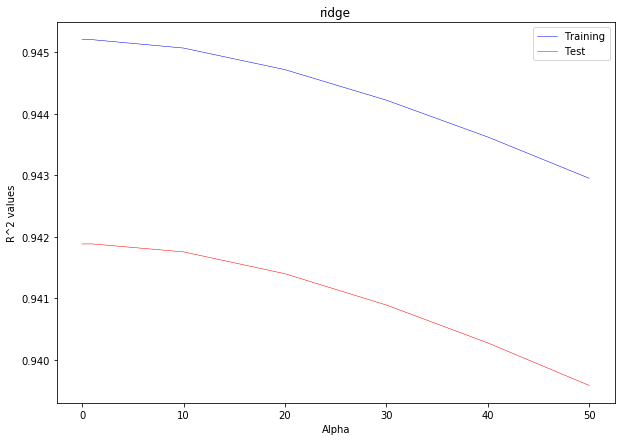

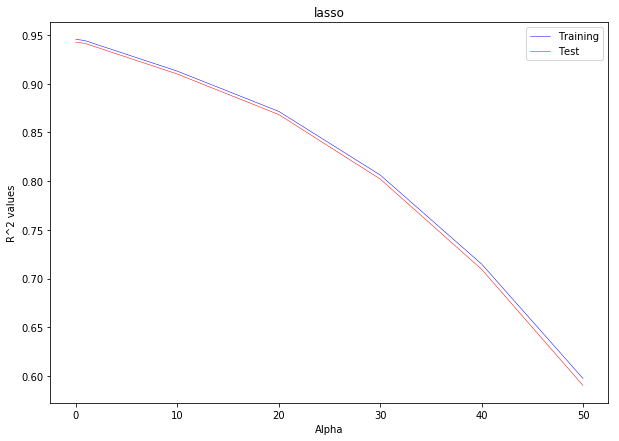

Model                                        Best parameters  Best cross-validation score
0       ridge                                  {'ridge__alpha': 0.5}                         0.94
1       lasso                                  {'lasso__alpha': 0.1}                         0.94
2  elasticnet  {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 1}                         0.94

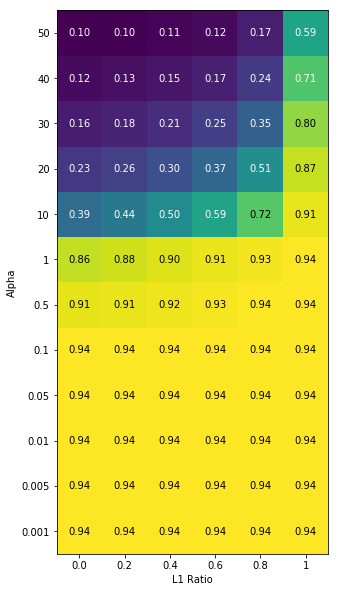

In [411]:
# Run Q3
ballframeClean = getFixedDataFrom(ballframe)
X_train, X_test, y_train, y_test, myOutput = runAlgorithmsQ3(ballframeClean, targetframe)
pd.DataFrame(myOutput, 
             columns = ["Model", 
#                         "Train score", 
#                         "Test score", 
                        "Best parameters", 
                        "Best cross-validation score"])

### Team discussion Q1.3

For this question we have selected the next values of the hyperparameters:

- `alpha` :  `[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 20, 30, 40, 50]`
- `l1_ratio`: `[0.0, 0.2, 0.4, 0.6, 0.8, 1]`

We have observe that with the optimized values, all algorithms reported an equal cross-validation score and the best parameters were reported to be `alpha = 0.5` for Ridge, `alpha = 0.1` for Lasso and ElasticNet and `l1_ratio = 1` for the latter. Indeed, the parameters of ElasticNet converted it into a Lasso regressor.

In general, the greater the alpha (regularization) the worse the result. For Ridge, which relies in a L2-regularization we conclude that aggresive regularization is not desired and for Lasso, which relies in L1-regularization, the same follows with even a lower alpha. ElasticNet prefered full L1-regularization.

We think that by focusing on values close to the optimal ones reported in this experiment, we could get better results.

4 . Visualize the coefficients of the optimized models. Do they agree on which features are
important? Compare the results with the feature importances returned by a RandomForest. Does it agree with the linear models? What would look for when scouting for a baseball player?

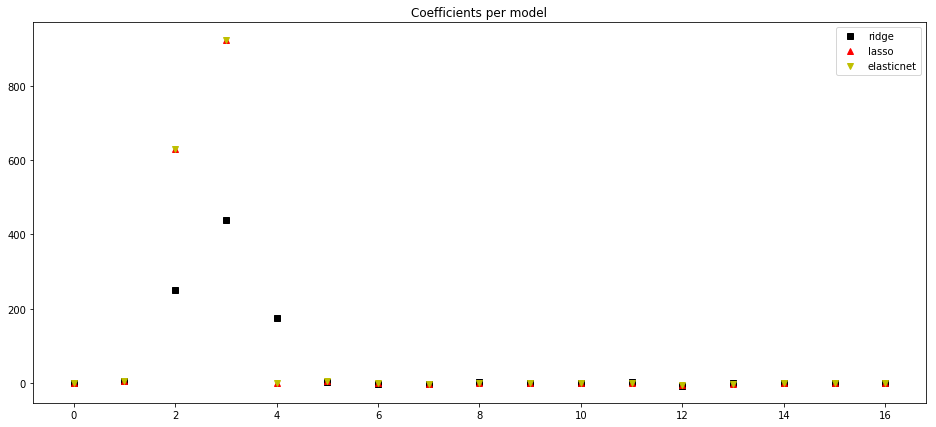

In [389]:
fig, axis = plt.subplots(figsize = (16, 7))

icons = {'lasso': '^', 'elasticnet': 'v', "ridge": 's'}
colors = {'lasso': 'r', 'elasticnet': 'y', "ridge": 'k'}

for name, pipeline in bests.items():
    model = pipeline.steps[1][1] 
    res = model.fit(X_train, y_train)
    if name == "ridge":
        coef = res.coef_[0, :] # Ridge returns an strange matrix, (1, 103)
    else:
        coef = res.coef_
    pl = plt.plot(coef, icons[name], label = name, c = colors[name])

t = plt.title("Coefficients per model")
l = plt.legend()
s = plt.show()


In [390]:
ballframeClean = getFixedDataFrom(ballframe)

dicoefs = {}
for name, pipeline in bests.items():
    model = pipeline.steps[1][1] 
    res = model.fit(X_train, y_train)
    if name == "ridge":
        coef = res.coef_[0, :] # Ridge returns an strange matrix, (1, 103), so we handle the case
    else:
        coef = res.coef_

    dicoefs[name] = pd.Series(abs(coef), index = ballframeClean.columns).sort_values(ascending = False)

    print('Most important features for best {} model :'.format(name))
    pd.DataFrame(dicoefs[name].sort_values(ascending = False)[dicoefs[name] > 0], columns = ["Coefficients for " + name])


Most important features for best ridge model :


Coefficients for ridge
SLG                           439.47
OBP                           250.75
BA                            174.96
W                               6.26
G_3.0                           6.02
G_2.0                           4.52
League_0.0                      2.82
League_1.0                      2.82
Playoffs_1.0                    2.26
Playoffs_0.0                    2.26
G_5.0                           1.26
RA                              0.70
G_6.0                           0.60
G_4.0                           0.53
G_1.0                           0.17

Most important features for best lasso model :


Coefficients for lasso
SLG                         9.24e+02
OBP                         6.30e+02
G_3.0                       5.48e+00
League_0.0                  5.23e+00
W                           4.78e+00
Playoffs_0.0                1.80e+00
G_4.0                       1.56e+00
G_5.0                       1.17e+00
RA                          5.08e-01
Playoffs_1.0                1.32e-15
League_1.0                  2.46e-16

Most important features for best elasticnet model :


Coefficients for elasticnet
SLG                              9.24e+02
OBP                              6.30e+02
G_3.0                            5.48e+00
League_0.0                       5.23e+00
W                                4.78e+00
Playoffs_0.0                     1.80e+00
G_4.0                            1.56e+00
G_5.0                            1.17e+00
RA                               5.08e-01
Playoffs_1.0                     1.32e-15
League_1.0                       2.46e-16

In [392]:
# Feature importance with Random Forest Regressor
dtree = RandomForestRegressor(max_depth = 4, random_state = 0)
fitdtree = dtree.fit(X_train, y_train)
feat_imp = dtree.feature_importances_
feat_imp_series = pd.Series(feat_imp, index = ballframeClean.columns)
pd.DataFrame(feat_imp_series[feat_imp_series > 0].sort_values(ascending = False), columns = ["Coefficients for Random Forest"])


Coefficients for Random Forest
SLG                        8.07e-01
OBP                        1.92e-01
RA                         4.09e-04
BA                         3.36e-04

### Team discussion Q1.4

In general, all algorithms agreed in having `OBP` and `SLG` as relevant features and gave `SLG` a higher coefficient. We can see that Ridge gives in general high coefficients and adds `BA` to the list of most important features (also observed in the plot). Differently, in Lasso (and consequently this version of ElasticNet) it is the `G_3.0` which plays an important role, but not as important as the others 2 (see plot). On the other hand, in Random Forest we can observe the 4 features that were found as candidates in the Exploratory Analysis because of its close-to-linear relation with the target but with a lower coefficient for `RA` and `BA`. 

In conclusion, `OBP` and `SLG` are the most important features to look at when scouting.


## Nepalese character recognition (5 points, 1+2+2)
The [Devnagari-Script dataset](https://www.openml.org/d/40923) contains 92,000 images (32x32 pixels) of 46 characters from Devanagari script. Your goal is to learn to recognize the right letter given the image.

In [189]:
devnagari = oml.datasets.get_dataset(40923) # Download Devnagari data
# Get the predictors X and the labels y
X, y = devnagari.get_data(target=devnagari.default_target_attribute); 
classes = devnagari.retrieve_class_labels(target_name='character') # This one takes a while, skip if not needed

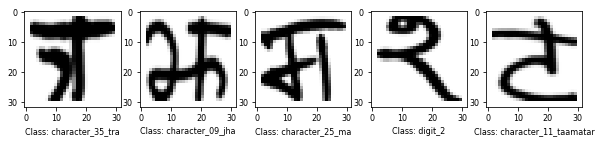

In [190]:
from random import randint
# Take some random examples, reshape to a 32x32 image and plot
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,90000)
    axes[i].imshow(X[n].reshape(32, 32), cmap=plt.cm.gray_r)
    axes[i].set_xlabel("Class: %s" % (classes[y[n]]))
plt.show();

1. Evaluate k-Nearest Neighbors, Logistic Regression and RandomForests with their default settings.
    - Take a stratified 10% subsample of the data.
    - Use the default train-test split and predictive accuracy. Is predictive accuracy a good scoring measure for this problem?
    - Try to build the same models on increasingly large samples of the dataset (e.g. 10%, 20%,...). Plot the training time and the predictive performance for each. Stop when the training time becomes prohibitively large (this will be different for different models). 

2 . Optimize the value for the number of neighbors $k$ (keep $k$ < 50) and the number of trees (keep $n\_estimators$ < 100) on the stratified 10% subsample.
- Use 10-fold crossvalidation and plot $k$ and $n\_estimators$ against the predictive accuracy. Which value of $k$, $n\_estimators$ should you pick?

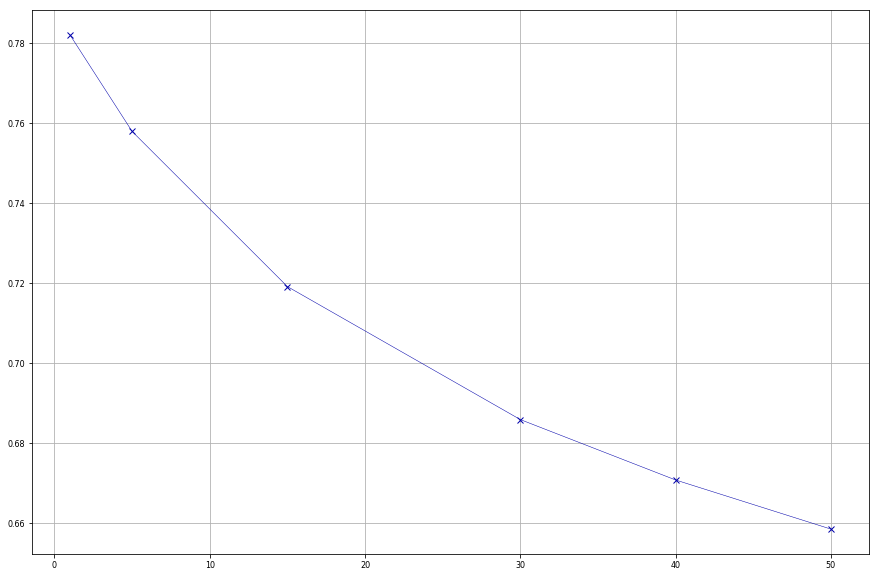

In [206]:
from sklearn.model_selection import cross_val_score

scores = []
estimators =[1,5,15,30,40,50]
knn = KNeighborsClassifier(n_jobs=-1)
for k in estimators:
    knn.n_neighbors=k
    scores.append(np.mean(cross_val_score(knn, xReduced, yReduced, cv=10)))

plt.figure(figsize=(15,10))
plt.plot(estimators, scores, marker="x")
plt.grid()
plt.show()

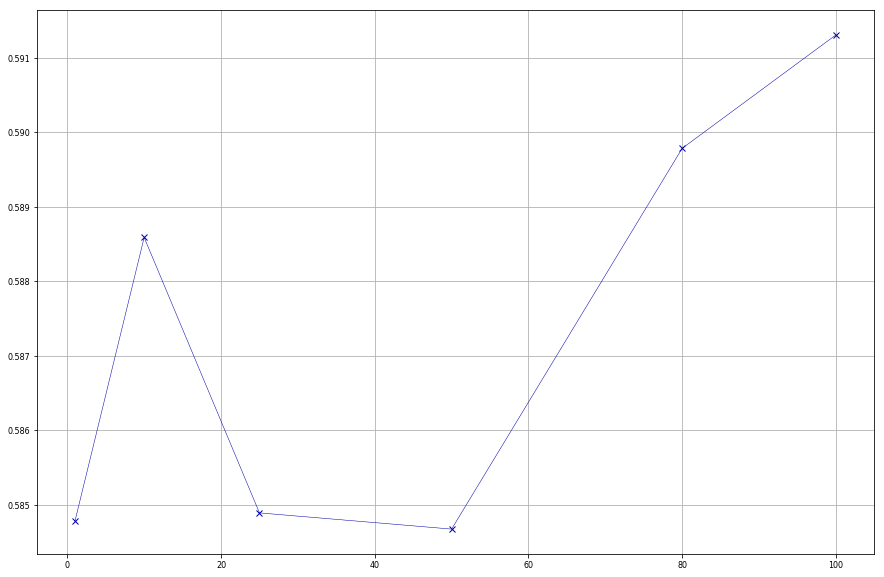

In [204]:
#---------------for random trees---------------------------------- 

from sklearn.model_selection import cross_val_score
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

#20,40,60,80,100

xReduced, _ , yReduced, _  = train_test_split(X,y, stratify=y, train_size=0.1)
x_train, x_test,y_train,y_test = train_test_split(xReduced,yReduced,stratify=yReduced, train_size=0.1)


scores = []
n_estimators = [1, 10, 25, 50, 80, 100]
rfc=RandomForestClassifier(n_jobs=-1)
for k in n_estimators:
    rfc.n_neighbors=k
    scores.append(np.mean(cross_val_score(rfc, xReduced, yReduced, cv=10)))
plt.figure(figsize=(15,10))
plt.plot(n_estimators, scores, marker="x")
plt.grid()
plt.show()

3 . For the RandomForest, optimize both $n\_estimators$ and $max\_features$ at the same time on the entire dataset.
- Use a nested cross-validation and a random search over the possible values, and measure the accuracy. Explore how fine-grained this random search can be, given your computational resources. What is the optimal performance you find?
- Hint: choose a nested cross-validation that is feasible. Don't use too many folds in the outer loop.
- Repeat the grid search and visualize the results as a plot (heatmap) $n\_estimators \times max\_features \rightarrow ACC$ with ACC visualized as the color of the data point. Try to make the grid as fine as possible. Interpret the results. Can you explain your observations? What did you learn about tuning RandomForests?

In [193]:
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

#RANDOM----------
rf = RandomForestClassifier(random_state=0)
param_grid = {'n_estimators': [8, 16], # 8
              'max_features': [0.5, 0.7]} # 0.4
alg = RandomizedSearchCV(rf, param_distributions=param_grid,n_iter=4, cv = 5)
start_time = time.time()
scores__randoms_nestedcv = cross_val_score(alg, X, y, cv = 3)
print("Cross-validation scores: ", scores__randoms_nestedcv)
print("Mean cross-validation score: ", scores__randoms_nestedcv.mean())
end_time = time.time()
print("total time:", (end_time - start_time))

Cross-validation scores:  [0.469 0.53  0.46  0.516 0.509]
Mean cross-validation score:  0.49678260869565216
total time: 871.097177028656


In [199]:
alg.fit(X, y)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=4, n_jobs=1,
          param_distributions={'n_estimators': [1, 2, 4], 'max_features': [0.1, 0.2, 0.3]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [200]:
alg.best_params_

{'max_features': 0.3, 'n_estimators': 4}

## 3. Understanding Ensembles (5 points (3+2))
Do a deeper analysis of how RandomForests and Gradient Boosting reduce their prediction error. We'll use the MAGIC telescope dataset (http://www.openml.org/d/1120). When high-energy particles hit the atmosphere, they produce chain reactions of other particles called 'showers', and you need to detect whether these are caused by gamma rays or cosmic rays.

In [9]:
# Get the data
magic_data = oml.datasets.get_dataset(1120) # Download MAGIC Telescope data
X, y = magic_data.get_data(target=magic_data.default_target_attribute);

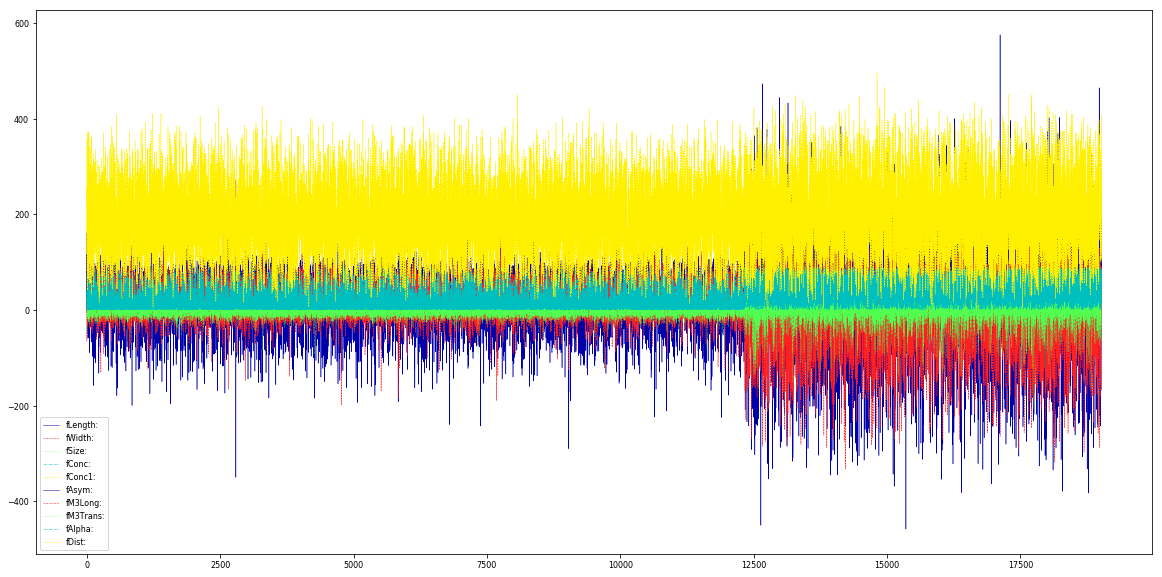

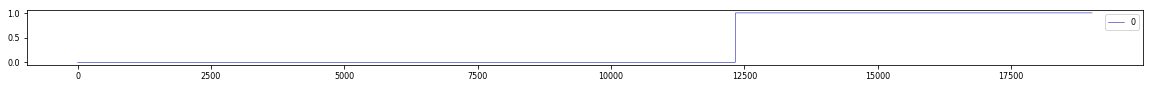

In [10]:
# Quick visualization
X, y, attribute_names = magic_data.get_data(target=magic_data.default_target_attribute, return_attribute_names=True)
magic = pd.DataFrame(X, columns=attribute_names)
magic.plot(figsize=(20,10))
# Also plot the target: 1 = gamma, 0 = background
pd.DataFrame(y).plot(figsize=(20,1));

1 . Do a bias-variance analysis of both algorithms. For each, vary the number of trees on a log scale from 1 to 1024, and plot the bias error (squared), variance, and total error (in one plot per algorithm). Interpret the results. Which error is highest for small ensembles, and which reduced most by each algorithm as you use a larger ensemble? When are both algorithms under- or overfitting? Provide a detailed explanation of why random forests and gradient boosting behave this way.
- See lecture 3 for an example on how to do the bias-variance decomposition
- To save time, you can use a 10% stratified subsample in your initial experiments, but show the plots for the full dataset in your report.

In [27]:
def doBiasVarianceAnalysis(X, y, clf, n_repeat = 100, test_percentage = 0.33):
    shuffle_split = ShuffleSplit(test_size = 0.33, n_splits=n_repeat)
    # Store sample predictions
    y_all_pred = [[] for _ in range(len(y))]
    
    # Train classifier on each bootstrap and score predictions
    for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
        # Train and predict
        clf.fit(X[train_index], y[train_index])
        y_pred = clf.predict(X[test_index])

        # Store predictions
        for i,index in enumerate(test_index):
            y_all_pred[index].append(y_pred[i])

    # Compute bias, variance, error
    bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat 
                for i,x in enumerate(y_all_pred)])
    var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
               for i,x in enumerate(y_all_pred)])
    error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat 
                for i,x in enumerate(y_all_pred)])
    
    return [bias_sq, var, error]


In [50]:
# From 1 to 1024
depths = [2 ** x for x in range(0, 11)]

biasDict = {'randomforest': [], 'gradientboosting': []}
varDict = {'randomforest': [], 'gradientboosting': []}
errDict = {'randomforest': [], 'gradientboosting': []}

start_time = time.time()
print("=====Running for RandomForestRegressor=====")
for depth in depths:
    print("\n\tWith depth", depth, "...")
    dtree = RandomForestRegressor(max_depth = depth, random_state = 0)
    partial_start_time = time.time()
    resbv = doBiasVarianceAnalysis(X, y, dtree)
    biasDict['randomforest'].append(resbv[0])
    varDict['randomforest'].append(resbv[1])
    errDict['randomforest'].append(resbv[2])
    partial_end_time = time.time()
    print("\tPartial time in seconds:", partial_end_time - partial_start_time)
end_time = time.time()
print("Time in seconds:", end_time - start_time)


print("\n\n=====Running for GradientBoostingClassifier=====")
start_time = time.time()
for depth in depths:
    print("\n\tWith depth", depth, "...")
    gbrt = GradientBoostingClassifier(random_state = 0, max_depth = depth)
    partial_start_time = time.time()
    resbv = doBiasVarianceAnalysis(X, y, gbrt)
    biasDict['gradientboosting'].append(resbv[0])
    varDict['gradientboosting'].append(resbv[1])
    errDict['gradientboosting'].append(resbv[2])
    partial_end_time = time.time()
    print("\tPartial time in seconds:", partial_end_time - partial_start_time)
end_time = time.time()
print("Time in seconds:", end_time - start_time)



=====Running for RandomForestRegressor=====

	With depth 1 ...
	Partial time in seconds: 11.211903095245361

	With depth 2 ...
	Partial time in seconds: 18.876446962356567

	With depth 4 ...
	Partial time in seconds: 30.936397075653076

	With depth 8 ...
	Partial time in seconds: 55.34031796455383

	With depth 16 ...
	Partial time in seconds: 87.13259196281433

	With depth 32 ...
	Partial time in seconds: 99.65315794944763

	With depth 64 ...
	Partial time in seconds: 99.50998902320862

	With depth 128 ...
	Partial time in seconds: 99.81245613098145

	With depth 256 ...
	Partial time in seconds: 99.58093118667603

	With depth 512 ...
	Partial time in seconds: 99.84629607200623

	With depth 1024 ...
	Partial time in seconds: 99.9650022983551
Time in seconds: 801.868735074997


=====Running for GradientBoostingClassifier=====

	With depth 1 ...
	Partial time in seconds: 46.32968521118164

	With depth 2 ...
	Partial time in seconds: 83.6764268875122

	With depth 4 ...
	Partial time in sec

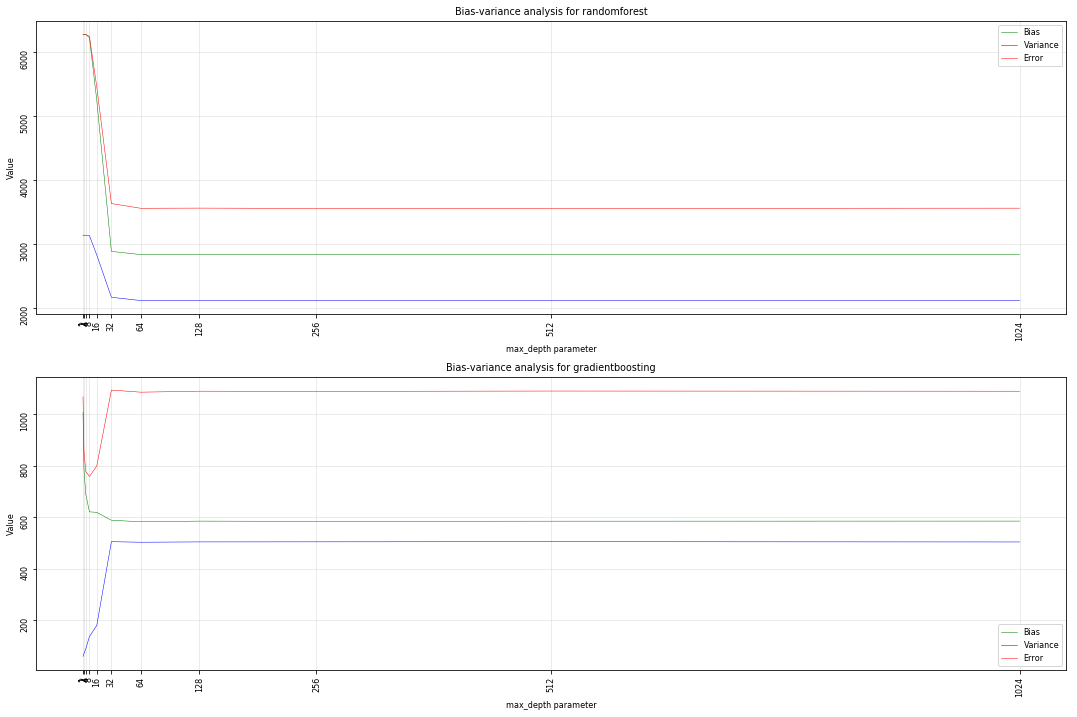

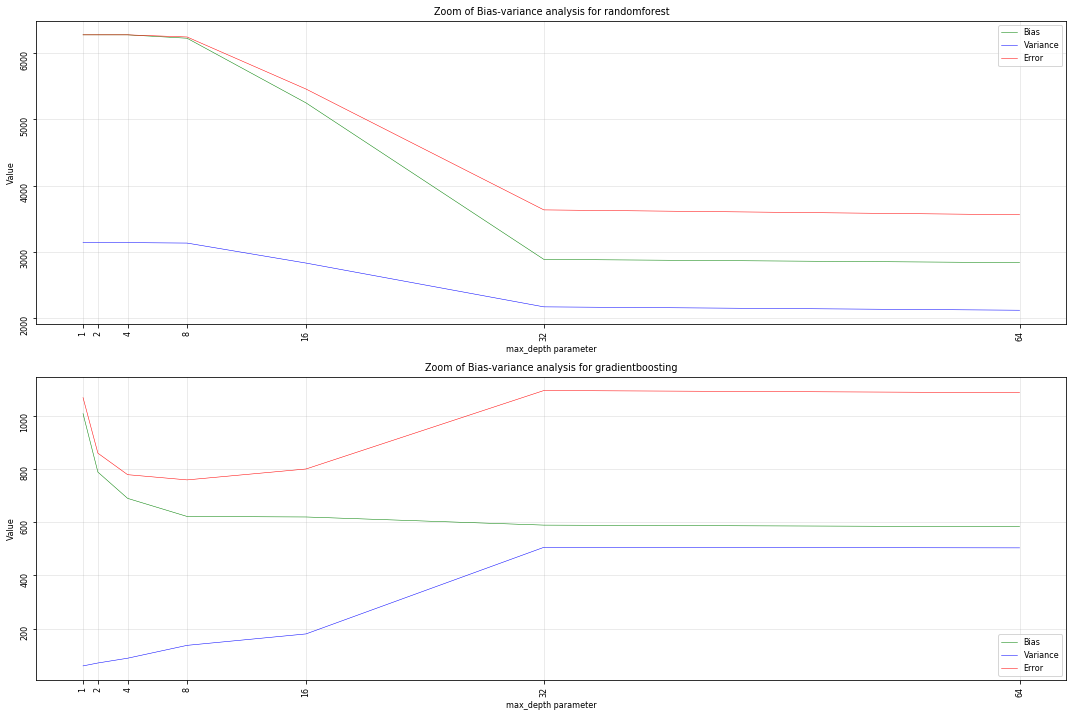

In [119]:
# Make the plot
fig, axes = plt.subplots(nrows = 2, ncols=1)

for i, axis in enumerate(axes.flatten()):
    if i == 0:
        name = "randomforest"
    else:
        name = "gradientboosting"
        
    fig.set_size_inches(15, 10)
    pl = axis.plot(depths, biasDict[name], '-g', label='Bias')
    pl = axis.plot(depths, varDict[name], '-b', label='Variance')
    pl = axis.plot(depths, errDict[name], '-r', label='Error')
    plxl = axis.set_xlabel("max_depth parameter")
    plyl = axis.set_ylabel("Value")
    leg = axis.legend()
    gr = axis.grid(visible = True, alpha = 0.3)
    tp = axis.tick_params(labelrotation= 90.)
    sxt = axis.set_xticks(depths)
    pltl = axis.set_title("Bias-variance analysis for " + name)
    fig.tight_layout()

fig, axes = plt.subplots(nrows = 2, ncols=1)

subsize = 7
for i, axis in enumerate(axes.flatten()):
    if i == 0:
        name = "randomforest"
    else:
        name = "gradientboosting"
        
    fig.set_size_inches(15, 10)
    pl = axis.plot(depths[:subsize], biasDict[name][:subsize], '-g', label='Bias')
    pl = axis.plot(depths[:subsize], varDict[name][:subsize], '-b', label='Variance')
    pl = axis.plot(depths[:subsize], errDict[name][:subsize], '-r', label='Error')
    plxl = axis.set_xlabel("max_depth parameter")
    plyl = axis.set_ylabel("Value")
    leg = axis.legend()
    gr = axis.grid(visible = True, alpha = 0.3)
    tp = axis.tick_params(labelrotation= 90.)
    sxt = axis.set_xticks(depths[:subsize])
    pltl = axis.set_title("Zoom of Bias-variance analysis for " + name)
    fig.tight_layout()



### Team discussion Q3.1

We find that _GradientBoosting_ gives the lowest total error in all cases (in range `(700, 1200)` vs. `(3000, 7000)` of _RandomForest_). For the second one, we observe that this total error is always decreasing while we increase `max_depth` and it starts to "stabilize" in `max_depth = 32`, where it remains approximately unchanged. This is due to the fact that both bias and variance are decreasing for every increase of depth. It comes to important to note that it does decrease variance since it is designed to reduce overfitting by averaging out individual predictions. In general for this ensamble, the greater the value for `max_depth` the best the performance of the algorithm.

On the other hand, for GradientBoosting we see that the best total error is found with low depths (between `1` and `8`) and then it starts to grow again. This is explained by knowing that it is intended to reduce bias (underfitting) but not variance (overfitting). We can indeed observe that this type of error is always growing but in `max_depth = 16` it changes drastically, meaning that we would start to overfit more if we choose this parameter value.

With these settings, we would prefer GradientBoosting with `max_depth = 4` or `max_depth = 8`, where a good balance of overfitting and underfitting is found.

2 . A _validation curve_ can help you understand when a model starts under- or overfitting. It plots both training and test set error as you change certain characteristics of your model, e.g. one or more hyperparameters. Build validation curves for gradient boosting, evaluated using AUROC, by varying the number of iterations between 1 and 500. In addition, use at least two values for the learning rate (e.g. 0.1 and 1), and tree depth (e.g. 1 and 4). This will yield at least 4 curves. Interpret the results and provide a clear explanation for the results. When is the model over- or underfitting? Discuss the effect of the different combinations learning rate and tree depth and provide a clear explanation.
- While scikit-learn has a `validation_curve` function, we'll use a modified version (below) that provides a lot more detail and can be used to study more than one hyperparameter. You can use a default train-test split.

In [185]:
# Plots validation curves for every classifier in clfs. 
# Also indicates the optimal result by a vertical line
# Uses 1-AUROC, so lower is better
def validation_curve(clfs, X_test, y_test, X_train, y_train, title):
    plt.figure(figsize=(15,10))
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    count = 0
    for n,clf in enumerate(clfs):
        test_score = np.empty(len(clf.estimators_))
        train_score = np.empty(len(clf.estimators_))

        for i, pred in enumerate(clf.staged_decision_function(X_test)):
            test_score[i] = 1-roc_auc_score(y_test, pred)

        for i, pred in enumerate(clf.staged_decision_function(X_train)):
            train_score[i] = 1-roc_auc_score(y_train, pred)

        best_iter = np.argmin(test_score)
        learn = clf.get_params()['learning_rate']
        depth = clf.get_params()['max_depth']
        test_line = plt.plot(test_score, linestyle = '-', color = colors[count],
                             label=' Test | learn=%.1f depth=%i (%.2f)'%(learn,depth,
#                              label=' Test | depth=%i (%.2f)'%(depth,
                                                                 test_score[best_iter]))
        count += 1
#         print(count)
        colour = test_line[-1].get_color()
        
        plt.plot(train_score, '-.', color=colour, label="Train")
        plt.xlabel("Number of boosting iterations")
        plt.ylabel("1 - AUROC")
        plt.cm
        plt.axvline(x=best_iter, color=colour)
        plt.title(title)
    plt.legend(loc='best')

	Running with params: n_estimators = 5 ; learning_rate = 0.1 ; max_depth = 4
	Partial time in seconds: 0.14217209815979004
	Running with params: n_estimators = 5 ; learning_rate = 0.1 ; max_depth = 8
	Partial time in seconds: 0.4017457962036133
	Running with params: n_estimators = 5 ; learning_rate = 1.0 ; max_depth = 4
	Partial time in seconds: 0.15072011947631836
	Running with params: n_estimators = 5 ; learning_rate = 1.0 ; max_depth = 8
	Partial time in seconds: 0.3684999942779541
	Running with params: n_estimators = 5 ; learning_rate = 2.0 ; max_depth = 4
	Partial time in seconds: 0.12175202369689941
	Running with params: n_estimators = 5 ; learning_rate = 2.0 ; max_depth = 8
	Partial time in seconds: 0.35920095443725586
	Running with params: n_estimators = 25 ; learning_rate = 0.1 ; max_depth = 4
	Partial time in seconds: 0.8577158451080322
	Running with params: n_estimators = 25 ; learning_rate = 0.1 ; max_depth = 8
	Partial time in seconds: 1.874079942703247
	Running with param

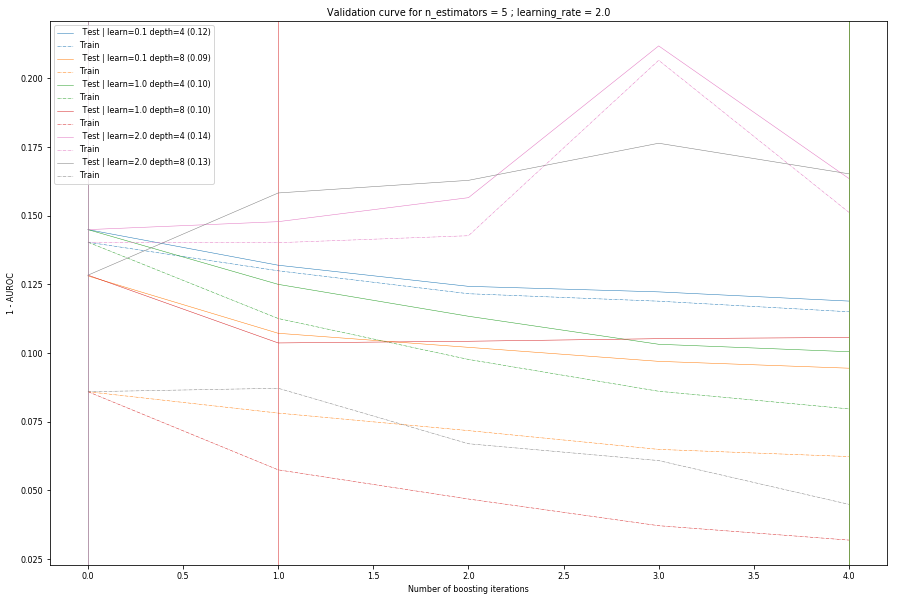

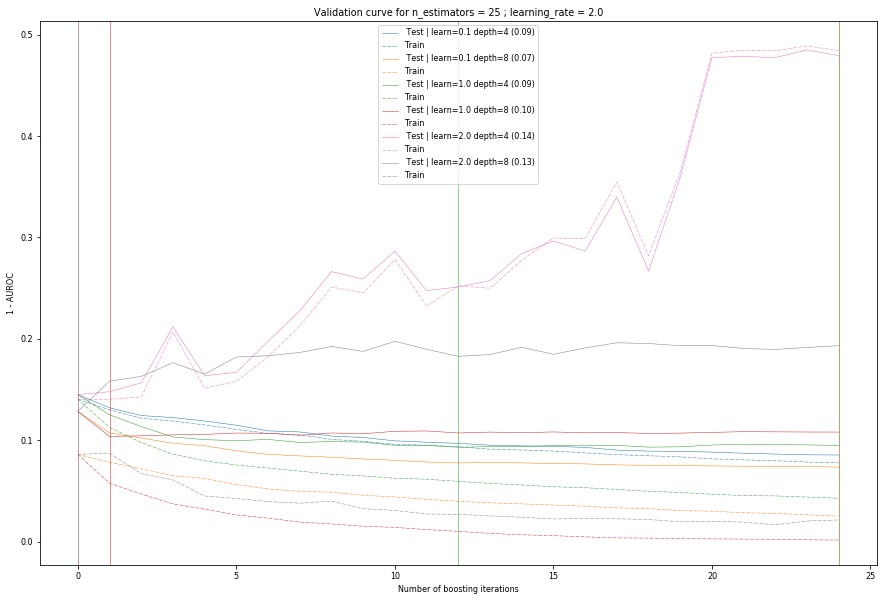

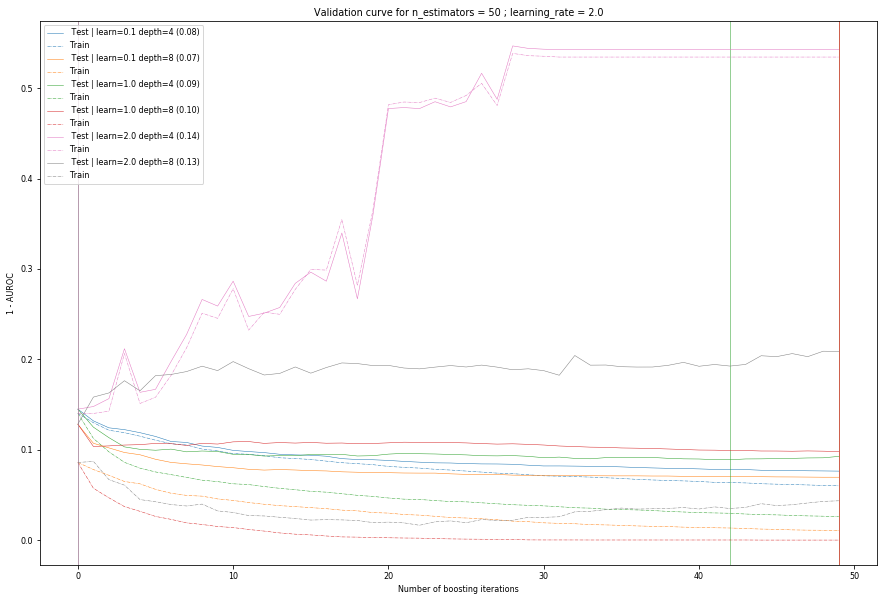

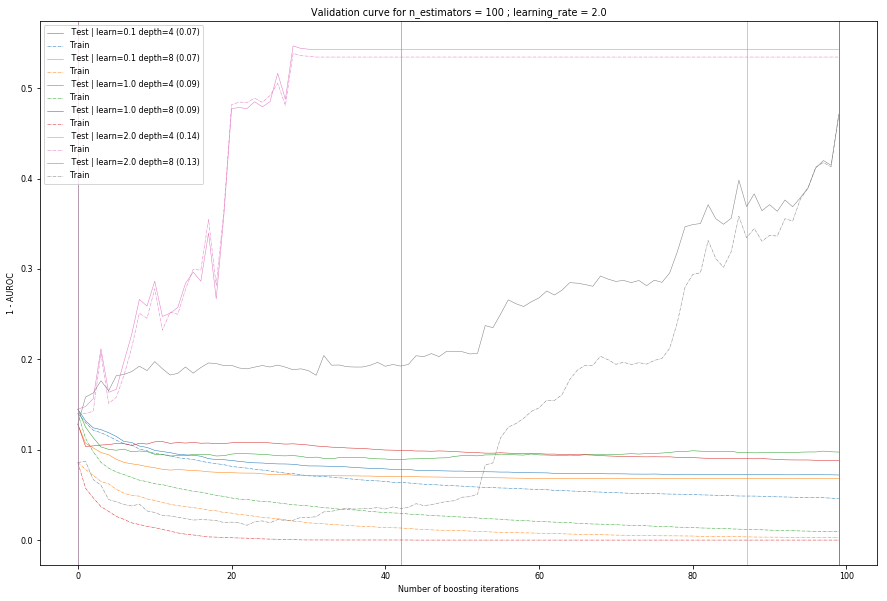

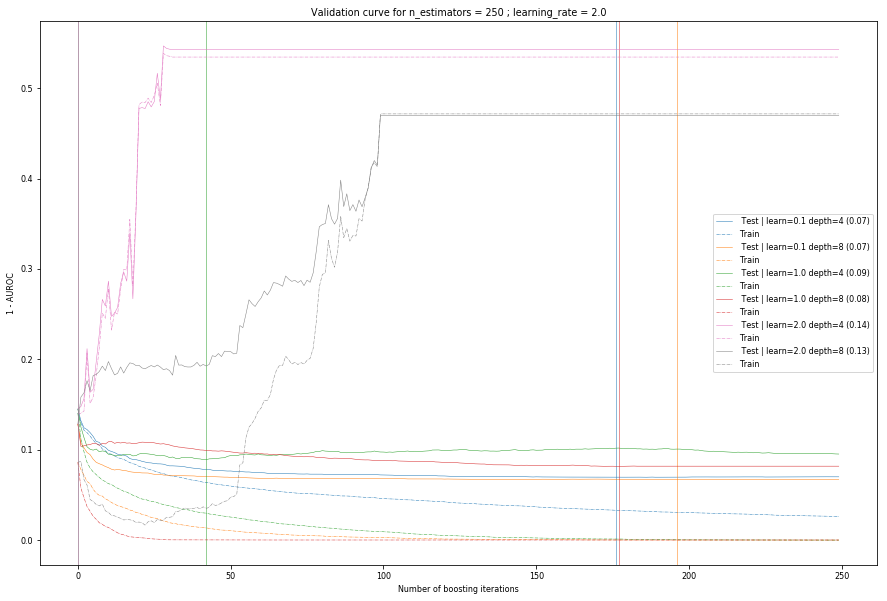

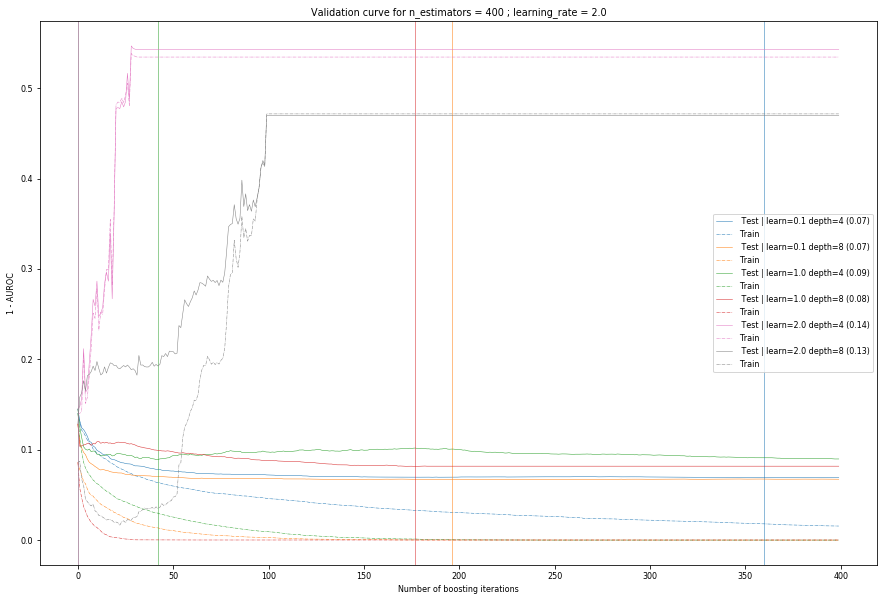

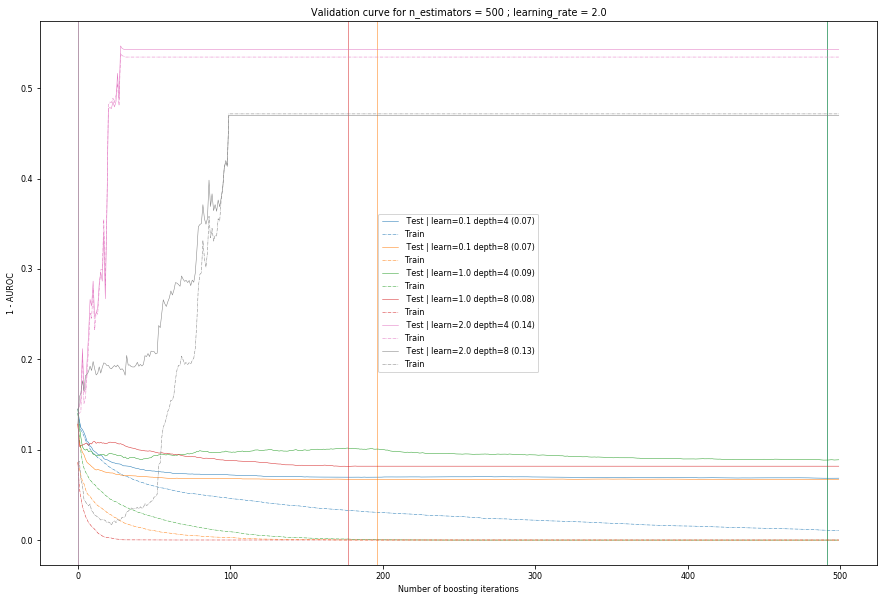

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

params = {"n_estimators" : [5, 25, 50, 100, 250, 400, 500], # Iterations
          "learning_rate" : [0.1, 1.0, 2.0] , # Learning rate
          "max_depth": [4, 8]} # Max depth

# List of classifiers to plot
classifiers = []

start_time = time.time()
# Run all combinations
for n_estimators in params["n_estimators"]:
    for learning_rate in params["learning_rate"]:
        for max_depth in params["max_depth"]:
            print("\tRunning with params: n_estimators = %s ; learning_rate = %s ; max_depth = %s" % (n_estimators, 
                                                                                                    learning_rate, 
                                                                                                    max_depth))
            partial_start_time = time.time()
            # Define classifier
            clf = GradientBoostingClassifier(random_state = 0, 
                                             max_depth = max_depth, 
                                             learning_rate = learning_rate,
                                             n_estimators = n_estimators)
            # Fit it
            fit = clf.fit(X_train, y_train)
            # Add it to result list
            classifiers.append(clf)
            partial_end_time = time.time()
            print("\tPartial time in seconds:", (partial_end_time - partial_start_time))
    sTitle = "Validation curve for n_estimators = {} ; learning_rate = {}".format(n_estimators, learning_rate)
    validation_curve(classifiers, X_test, y_test, X_train, y_train, sTitle )
    classifiers = []


end_time = time.time()
print("Total time for all combinations (in seconds):", (end_time - start_time))


### Team discussion Q3.2

The first thing to keep in mind is that there is a trade-off between `learning_rate` and `n_estimators`. Hence we first explain the general behavior for this combinations.

It is expected that high values of `n_estimators` give a worse value for RUC in models using a high `learning_rate`, we can confirm that by looking at lines in pink and gray where the `learning_rate = 2.0`. For them we obtain the best result in the very first iterations and clearly they perform worse while `n_estimators` increases. Contrarely, for learning rates of `0.1` and `1.0` we can observe that optimal results are found in high itarations. Now we are going to discuss in detail for each of the combinations, by colorline.

**Blue line: `learning_rate = 0.1`, `depth = 4`**

**Yellow line: `learning_rate = 0.1`, `depth = 8`**

**Green line: `learning_rate = 1.0`, `depth = 4`**

**Red line: `learning_rate = 1.0`, `depth = 8`**

**Pink line: `learning_rate = 2.0`, `depth = 4`**

**Gray line: `learning_rate = 2.0`, `depth = 8`**